# Emergent Abilities in Large Language Models
Wei, Jason, et al (2022)

This notebook explores the following key ideas from the paper,
- The emergence trends in a family of LLMs
- The disappearance of emergence trends when a continuous metric is used.

In this notebook the emergence trends in FLAN-T5 Model family is explored. To the best of the author's knowledge a emergence trends study on the FLAN-T5 family is not done.

## FLAN-T5

The FLAN-T5 models were released in the paper "Scaling instruction-finetuned language models", Chung, Hyung Won, et al.(2024). FLAN-T5 is an instruction-tuned version of T5 that has been finetuned on a mixutre of tasks. The smllest model (flan-t5-small) has 80M parameters and the largest model (flan-t5-xxl) has 11B parameters. For the study on emergence, we use the models from 80M upto 3B size.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


**NOTE:** The code requires HF_TOKEN to be set. Set that in secrets section of GOOGLE Colab

In [2]:
flan_family = ['google/flan-t5-small', 'google/flan-t5-base', 'google/flan-t5-large', 'google/flan-t5-xl']
flan_family_size = [80, 250, 780, 3000] # In Million

In [3]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained(flan_family[0])

option_letters = 'ABCD'
option_indices = tokenizer.encode('A B C D')[:-1]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
def format_data_point(x):
    """Prepares the prompt for the model"""

    options_for_qu = "\n".join([option_letters[i]+") "+option for i, option in enumerate(x['choices'])])

    return "\n".join((
        "Question: Answer the following multiple choice question.",
        x['question'],
        "Options:",
        options_for_qu,
        "Answer:"
    ))

In [5]:
def is_correct_answer(model_answer, actual_ans):
    return model_answer == option_letters[actual_ans]

## Task description and Methodology

- The MMLU dataset introduced by Hendrycks, Dan, et al.(2020) is used in the experiment. It's an MCQ dataset, where each question has 4 options.
- For the discontinuous metric and the continuous metric, Accuracy score and Brier Score are used respectively.
- MMLU datset has 57 tasks. From those tasks we filter out emergent tasks by identifying the tasks which have close to random performance for the smaller models but observe a spike in performance when using the larger models. The filteration technique is inspired from Wei, Jason, et al (2022).

#### Brier Score
- Brier scores calculates the Mean Squared Error between the One-Hot encoding of the target class and the probability of each class predicted by the model.
$$
    \frac{1}{N}\sum_{i=1}^{N} \sum_{j=1}^{R} (f_{i,j} - p_{i,j})^2
$$

where $R$ is number of classes, $p_{i,j}$ is predicted probability of jth class for ith datapoint, $N$ is total number of datapoints and $f_{i,j}$ is 1 is ith target class is j and 0 otherwise.
- From statistical experiments the average Brier score for a model that gives random probabilities as predictions, was found out to be 0.8281. (Used later in the notebook)
- Range of Brier score for task with 4 classes is [0,2]


In [6]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from torch.nn import functional as F

def evaluate_dataset(ds):
    results_dict = {}
    for model_name in flan_family:
        tokenizer = T5Tokenizer.from_pretrained(model_name)
        model = T5ForConditionalGeneration.from_pretrained(model_name, device_map="auto")

        correct_counter = 0
        brier_score = 0

        for x in ds['validation']:

            input_text = format_data_point(x)
            if len(tokenizer.tokenize(input_text)) > 505:
                return None

            input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")
            outputs = model.generate(input_ids, return_dict_in_generate=True, output_scores=True)

            option_logits = outputs.scores[0][0, option_indices]
            answer = torch.argmax(option_logits)

            if answer == x['answer']:
                correct_counter += 1

            #Brier Score Calculation
            answer_probs = F.softmax(option_logits, dim=0)
            answer_probs = answer_probs.detach().cpu()
            expected_probs = torch.zeros(4)
            expected_probs[x['answer']] = 1
            brier_score += torch.sum((expected_probs - answer_probs)**2)


        results_dict[model_name] = {
            "accuracy": correct_counter/len(ds['validation']),
            "brier_score": brier_score/len(ds['validation'])
        }

    return results_dict


In [7]:
subjects = set()
from datasets import load_dataset

ds = load_dataset("cais/mmlu", "all")
for x_p in ds['validation']:
    subjects.add(x_p['subject'])
print(subjects)

README.md:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/138k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/408k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

auxiliary_train-00000-of-00001.parquet:   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1531 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/285 [00:00<?, ? examples/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

{'security_studies', 'professional_psychology', 'anatomy', 'clinical_knowledge', 'virology', 'human_sexuality', 'college_physics', 'high_school_mathematics', 'moral_disputes', 'prehistory', 'professional_law', 'human_aging', 'miscellaneous', 'formal_logic', 'international_law', 'high_school_statistics', 'philosophy', 'professional_accounting', 'sociology', 'machine_learning', 'management', 'marketing', 'public_relations', 'us_foreign_policy', 'elementary_mathematics', 'business_ethics', 'logical_fallacies', 'professional_medicine', 'high_school_government_and_politics', 'college_mathematics', 'high_school_biology', 'high_school_geography', 'conceptual_physics', 'global_facts', 'high_school_us_history', 'econometrics', 'moral_scenarios', 'high_school_european_history', 'computer_security', 'high_school_chemistry', 'college_biology', 'electrical_engineering', 'college_chemistry', 'high_school_computer_science', 'high_school_physics', 'astronomy', 'college_medicine', 'high_school_world_hi

In [8]:
import tqdm
ds_subject_wise = {sub:load_dataset("cais/mmlu", sub) for sub in tqdm.tqdm(subjects)}

results_subject_wise = []
subs = ['college_computer_science', 'professional_medicine', 'college_medicine', 'world_religions', 'human_aging']
# subs = subjects (Do this to run the experiment on the whole dataset, and then filter out the emergent behaviors)
for sub in (pbar:=tqdm.tqdm(subs)):
    ds_sub = ds_subject_wise[sub]
    pbar.set_description(sub)
    results = evaluate_dataset(ds_sub)
    results_subject_wise.append((sub, results))

  0%|          | 0/57 [00:00<?, ?it/s]

test-00000-of-00001.parquet:   0%|          | 0.00/114k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/7.49k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/245 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/27 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

  2%|▏         | 1/57 [00:03<03:09,  3.38s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/133k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/22.1k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.69k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/612 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/69 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

  4%|▎         | 2/57 [00:05<02:34,  2.81s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/5.28k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.50k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/135 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/14 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

  5%|▌         | 3/57 [00:08<02:17,  2.54s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/40.5k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/7.48k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.67k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/265 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

  7%|▋         | 4/57 [00:09<02:01,  2.30s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/27.3k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/166 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/18 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

  9%|▉         | 5/57 [00:12<01:55,  2.23s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/23.2k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/5.26k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.08k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/131 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 11%|█         | 6/57 [00:14<01:57,  2.31s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.39k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.51k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/102 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 12%|█▏        | 7/57 [00:16<01:57,  2.36s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.99k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.50k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/270 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 14%|█▍        | 8/57 [00:19<01:58,  2.42s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/60.9k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.41k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/346 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/38 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 16%|█▌        | 9/57 [00:21<01:49,  2.28s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/54.3k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/9.89k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.62k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/324 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/35 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 18%|█▊        | 10/57 [00:23<01:46,  2.26s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/116k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1534 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/170 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 19%|█▉        | 11/57 [00:26<01:44,  2.27s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/31.2k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.28k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.67k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/223 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 21%|██        | 12/57 [00:28<01:40,  2.24s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/98.6k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.37k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/783 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/86 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 23%|██▎       | 13/57 [00:30<01:35,  2.18s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/21.5k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.56k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.81k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/14 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 25%|██▍       | 14/57 [00:32<01:33,  2.18s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/29.5k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/7.12k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.96k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/121 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 26%|██▋       | 15/57 [00:34<01:30,  2.16s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/58.0k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/6.07k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/216 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 28%|██▊       | 16/57 [00:36<01:28,  2.16s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/48.6k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/9.15k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.20k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/311 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/34 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 30%|██▉       | 17/57 [00:38<01:25,  2.13s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/69.5k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.89k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/282 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/31 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 32%|███▏      | 18/57 [00:40<01:22,  2.12s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/201 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 33%|███▎      | 19/57 [00:43<01:23,  2.20s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.17k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/5.25k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/112 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 35%|███▌      | 20/57 [00:45<01:21,  2.20s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/4.50k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.61k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/103 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 37%|███▋      | 21/57 [00:47<01:19,  2.20s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/37.3k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.28k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/234 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 39%|███▊      | 22/57 [00:49<01:17,  2.22s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.45k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.43k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/110 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 40%|████      | 23/57 [00:51<01:13,  2.15s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/5.27k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.22k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 42%|████▏     | 24/57 [00:54<01:11,  2.16s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/41.1k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/9.38k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.55k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/378 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/41 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 44%|████▍     | 25/57 [00:56<01:08,  2.14s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.96k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 46%|████▌     | 26/57 [00:58<01:04,  2.09s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.52k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/163 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/18 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 47%|████▋     | 27/57 [01:00<01:01,  2.06s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/125k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/8.45k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/272 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/31 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 49%|████▉     | 28/57 [01:02<01:01,  2.11s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/40.2k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/8.27k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/193 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 51%|█████     | 29/57 [01:04<01:01,  2.18s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/5.00k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 53%|█████▎    | 30/57 [01:06<00:59,  2.19s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/310 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 54%|█████▍    | 31/57 [01:09<00:58,  2.24s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/28.2k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.16k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.93k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/198 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 56%|█████▌    | 32/57 [01:11<00:56,  2.27s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/25.0k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/5.98k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.96k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/26 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 58%|█████▊    | 33/57 [01:13<00:54,  2.29s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.58k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 60%|█████▉    | 34/57 [01:16<00:54,  2.36s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/155k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/27.3k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/204 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 61%|██████▏   | 35/57 [01:19<00:55,  2.52s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/7.02k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/114 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 63%|██████▎   | 36/57 [01:21<00:49,  2.37s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/89.8k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/5.14k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/895 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 65%|██████▍   | 37/57 [01:23<00:44,  2.25s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/142k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/31.6k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/165 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/18 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 67%|██████▋   | 38/57 [01:25<00:40,  2.14s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/19.1k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.67k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.33k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 68%|██████▊   | 39/57 [01:27<00:38,  2.12s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/33.3k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/8.31k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.16k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/203 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 70%|███████   | 40/57 [01:29<00:38,  2.28s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/31.8k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.90k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.27k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/144 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 72%|███████▏  | 41/57 [01:32<00:35,  2.24s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/17.6k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/5.08k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.08k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/145 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 74%|███████▎  | 42/57 [01:34<00:34,  2.30s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/4.87k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 75%|███████▌  | 43/57 [01:37<00:33,  2.40s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/27.3k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/5.28k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/6.54k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 77%|███████▋  | 44/57 [01:39<00:31,  2.39s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/33.0k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/7.96k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.57k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/151 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/17 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 79%|███████▉  | 45/57 [01:42<00:29,  2.44s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/28.3k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.05k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/152 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 81%|████████  | 46/57 [01:44<00:27,  2.50s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/42.5k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/8.99k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.84k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/173 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 82%|████████▏ | 47/57 [01:47<00:25,  2.53s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/202k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/38.5k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/237 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/26 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 84%|████████▍ | 48/57 [01:49<00:22,  2.56s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/16.4k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/5.63k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 86%|████████▌ | 49/57 [01:51<00:18,  2.37s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/18.9k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.30k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/171 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/19 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 88%|████████▊ | 50/57 [01:53<00:15,  2.26s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/54.8k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/9.89k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/390 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/43 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 89%|████████▉ | 51/57 [01:56<00:14,  2.36s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.21k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.05k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/108 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 91%|█████████ | 52/57 [01:58<00:11,  2.22s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/55.0k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.99k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/306 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/33 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 93%|█████████▎| 53/57 [02:00<00:08,  2.13s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/38.8k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/7.22k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.83k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/238 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/26 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 95%|█████████▍| 54/57 [02:02<00:06,  2.07s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.25k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/6.81k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 96%|█████████▋| 55/57 [02:04<00:04,  2.04s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/92.8k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/545 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/60 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

 98%|█████████▊| 56/57 [02:06<00:02,  2.14s/it]

test-00000-of-00001.parquet:   0%|          | 0.00/9.96k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

college_computer_science:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

professional_medicine:  20%|██        | 1/5 [03:02<12:11, 182.90s/it]   

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

college_medicine:  40%|████      | 2/5 [05:05<07:22, 147.51s/it]     

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

world_religions:  60%|██████    | 3/5 [06:54<04:19, 129.67s/it] 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

human_aging:  80%|████████  | 4/5 [08:38<01:59, 119.82s/it]    

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

human_aging: 100%|██████████| 5/5 [10:28<00:00, 125.61s/it]


In [9]:
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

def result_is_emergent(result_dict: dict[str, int]):
    """Filters out the tasks which are emergent"""

    if result_dict == None:
        return False

    values = [v['accuracy'] for v in result_dict.values()]

    if non_decreasing(values) and values[0] < 0.28 and values[1] < 0.3 and values[-1] >= 0.45:
        return True
    else:
        return False

In [10]:
emergent_subjects = []

for (sub, results) in tqdm.tqdm(results_subject_wise):
    if result_is_emergent(results):
        emergent_subjects.append((sub, results))

100%|██████████| 5/5 [00:00<00:00, 40642.48it/s]


In [11]:
print([sub for sub, results in emergent_subjects])

['college_computer_science', 'professional_medicine', 'college_medicine', 'world_religions', 'human_aging']


## Results

The scores are plotted against the model size in log scale. The emergence trend is observed when plotting the accuracy scores. But the trend disappears when plotting with Brier Score.

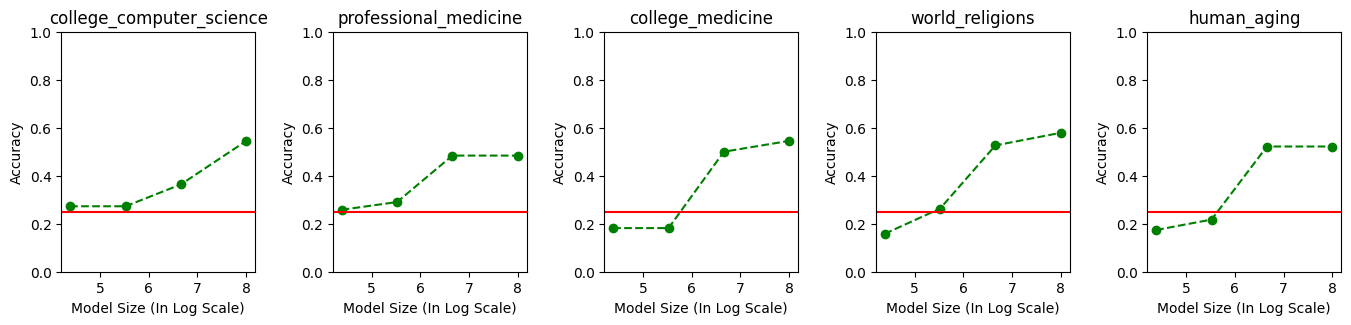

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,5, figsize=(16, 3))

for i, (sub, results) in enumerate(emergent_subjects):

    values = [v['accuracy'] for v in results.values()]
    ax[i%5].plot(np.log(flan_family_size), np.array(list(values)), linestyle='--', marker='o', color='g')
    ax[i%5].axhline(y = 0.25, color = 'r', linestyle = '-')
    ax[i%5].set_title(sub)
    ax[i%5].set_ylim([0, 1])

    ax[i%5].set_xlabel("Model Size (In Log Scale)")
    ax[i%5].set_ylabel("Accuracy")

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9,
                    top=0.9, bottom=0.1,
                    wspace=0.4, hspace=0.4)
plt.show()

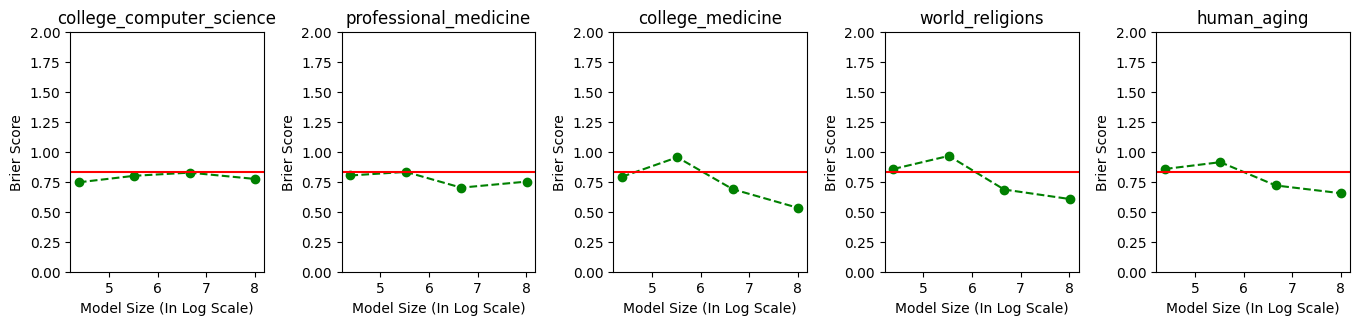

In [13]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 5, figsize=(16, 3))

for i, (sub, results) in enumerate(emergent_subjects):

    values = [v['brier_score'] for v in results.values()]
    ax[i%5].plot(np.log(flan_family_size), np.array(list(values)), linestyle='--', marker='o', color='g')
    ax[i%5].set_title(sub)
    ax[i%5].axhline(y = 0.8281, color = 'r', linestyle = '-')
    ax[i%5].set_ylim([0, 2])

    ax[i%5].set_xlabel("Model Size (In Log Scale)")
    ax[i%5].set_ylabel("Brier Score")

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9,
                    top=0.9, bottom=0.1,
                    wspace=0.4, hspace=0.4)
plt.show()

## References

Wei, Jason, et al. "Emergent abilities of large language models." arXiv preprint arXiv:2206.07682 (2022).\
Chung, Hyung Won, et al. "Scaling instruction-finetuned language models." Journal of Machine Learning Research 25.70 (2024): 1-53. \
Schaeffer, Rylan, et al. "Are emergent abilities of large language models a mirage?." Advances in Neural Information Processing Systems 36 (2024).\
Hendrycks, Dan, et al. "Measuring massive multitask language understanding." arXiv preprint arXiv:2009.03300 (2020).

## Appendix

#### Brier Score Average Calculation

This is how the average value of 0.8281 was calculated. (I kindly request anyone with better mathematical background to point out if they see any mistakes in my process)

In [18]:
import torch

N = 10000000

x = torch.rand((N, 4))
x = x/torch.sum(x, dim=1, keepdim=True)

y = torch.rand((N, 4))
y = torch.eq(y, torch.max(y, dim=1, keepdim=True).values).float()

brier_score = torch.sum((x - y)**2)/N
print(brier_score)

tensor(0.8281)
